In [1]:
!pip install fuzzywuzzy

In [51]:
import warnings
warnings.filterwarnings("ignore")

In [39]:
# import required packages
import pandas as pd
import numpy as np

from fuzzywuzzy import process, fuzz
from scipy.stats import f,t
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
import pylab as py
sns.set(style = 'darkgrid')

In [24]:
# read the data
df = pd.read_csv('D:\\Password-Analysis\\Datasets\\top_200_password_2020_by_country_extended.csv')
df.head()

,country_code,country,Rank,Password,User_count,Time_to_crack,Global_rank,Time_to_crack_in_seconds,length,unique_chars,numbers,symbols,symbols_and_numbers,sequentials
0,cn,China,1,123456,8159358,< 1 second,1.0,0,6,6,6,0,6,0
1,cn,China,2,123456789,1817250,< 1 second,2.0,0,9,9,9,0,9,0
2,cn,China,3,12345678,700019,< 1 second,6.0,0,8,8,8,0,8,0
3,cn,China,4,654321,245827,< 1 second,23.0,0,6,6,6,0,6,0
4,cn,China,5,1234567890,210168,< 1 second,9.0,0,10,10,10,0,10,0


In [27]:
df.Time_to_crack_in_seconds.unique()

array([        0,       120,         8,         2,      1020,     10800,
            7200,         7,   1036800,       240,        10,     86400,
              60,        11,     39600,         3,        41,        26,
            1440,     14400,         1,      3600,    950400,       600,
         2332800,       540,        17,    345600,         4,     50400,
              22,       180,         5,        34,  26784000,        28,
               9,        32,  96422400,  10713600,         6,        13,
              42,      1560,       420,  16070400, 996364800,     54000,
            2940,       360,     61200,        20,     21600,     57600,
       128563200,        55,       300,     43200], dtype=int64)

In [25]:
# get country codes
df.country_code.unique()

array(['cn', 'ru', 'es', 'us', 'vn'], dtype=object)

In [5]:
# get countrywise data
df_cn = df.loc[df['country_code'] == 'cn']
df_ru = df.loc[df['country_code'] == 'ru']
df_es = df.loc[df['country_code'] == 'es']
df_us = df.loc[df['country_code'] == 'us']
df_vn = df.loc[df['country_code'] == 'vn']

In [6]:
# defining function to calculate the fuzzy score
def fuzzy_similarity(password_df):
        """
        Function to calculate the fuzzy score between different passwords
        Args:
        password_df -- the password columns in the dataframe
        Returns:
        Dataframe with fuzzy score between individual passwords with rest of the passwords
        """

        # calculate the fuzzy score
        fuzzy_score = [(x,) + i
                        for x in password_df 
                        for i in process.extract(x, password_df, scorer=fuzz.token_sort_ratio)]

        # create dataframe from above calculated score
        fuzzy_df = pd.DataFrame(fuzzy_score, columns=['password','match','score', 'index'])

        # drop the last column as it is not needed
        fuzzy_df.drop(columns='index', inplace=True)

        # remove the score calculation itself
        fuzzy_df = fuzzy_df[fuzzy_df['password'] != fuzzy_df['match']]

        return fuzzy_df
    

In [7]:
# calculating fuzzy score for each country
fuzzy_df_cn = fuzzy_similarity(df_cn['Password'])
fuzzy_df_ru = fuzzy_similarity(df_ru['Password'])
fuzzy_df_es = fuzzy_similarity(df_es['Password'])
fuzzy_df_us = fuzzy_similarity(df_us['Password'])
fuzzy_df_vn = fuzzy_similarity(df_vn['Password'])

In [8]:
# adding country codes to the individual dataframes
fuzzy_df_cn['country_code'] = 'cn'
fuzzy_df_us['country_code'] = 'us'
fuzzy_df_ru['country_code'] = 'ru'
fuzzy_df_es['country_code'] = 'es'
fuzzy_df_vn['country_code'] = 'vn'

# combining all the scores in one datafram
fuzzy_scores = pd.DataFrame(data = fuzzy_df_cn, columns=['country_code', 'password', 'match', 'score'])
fuzzy_scores = fuzzy_scores.append(fuzzy_df_es, ignore_index=True)
fuzzy_scores = fuzzy_scores.append(fuzzy_df_ru, ignore_index=True)
fuzzy_scores = fuzzy_scores.append(fuzzy_df_us, ignore_index=True)
fuzzy_scores = fuzzy_scores.append(fuzzy_df_vn, ignore_index=True)

## Performing Statistical Analysis

### Hypothesis 1

Null Hypothesis: We hypothesize that the passwords will be identical across different languages and countries.

$$
H_0: \mu_{China} = \mu_{United States} = \mu_{Russia} = \mu_{Spain} = \mu_{Vietnam}
$$

Alternate Hypothesis: The password are not identical accross different languages and countries.

ANOVA is the most suitable approach for these kinds for tests, so before performing ANOVA we will first check if all the required assumptions are met or not to perform ANOVA.

ANOVA test is based on the following assumptions:
1. Data is normally distributed
2. Homogeneity of variance
3. Observation are independent of each other

**Independence of Data**

The dataset is idependent as all values are gathered for different countries and it is not associated with each other.

**Checking for Normality**

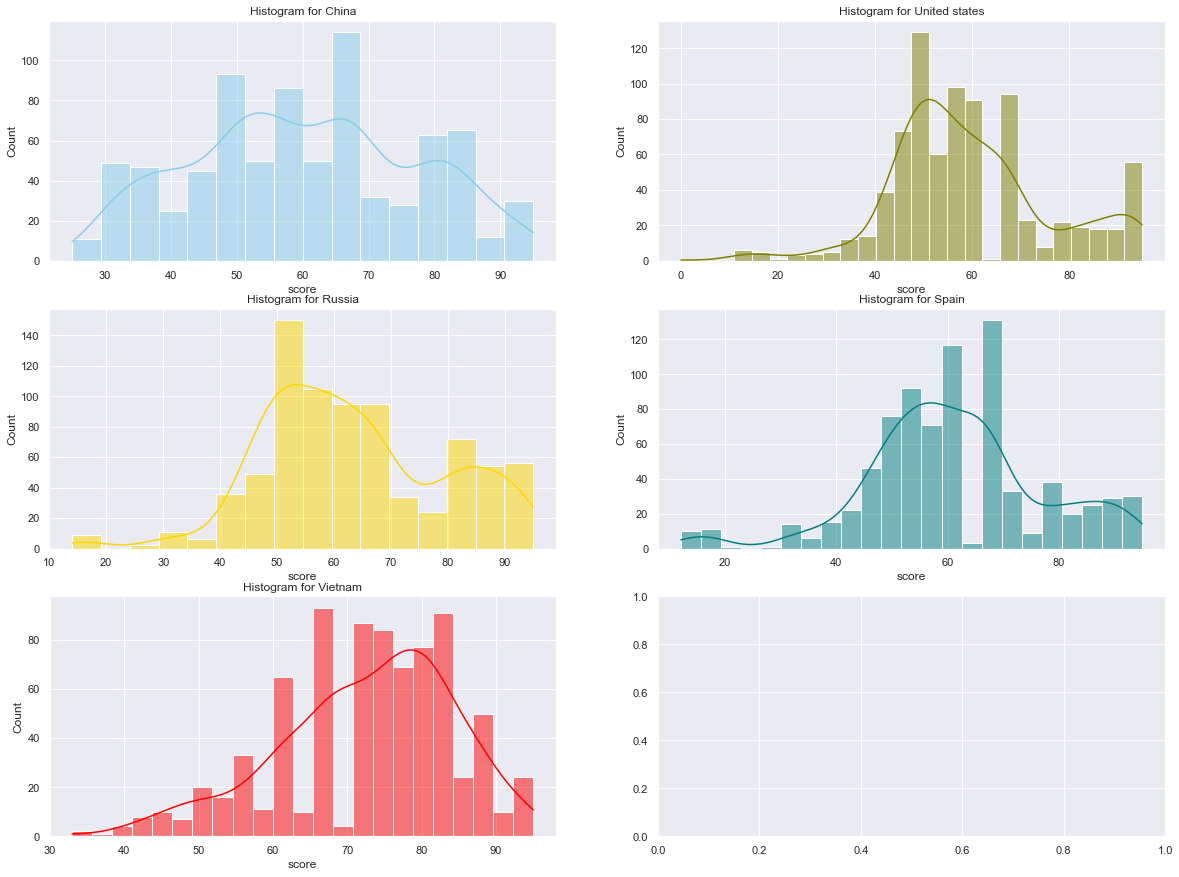

In [55]:
# plotting the histograms
fig, axes = plt.subplots(3, 2, figsize=(20,15))

sns.histplot(data=fuzzy_df_cn, x = "score", kde = True, color="skyblue", ax=axes[0,0])
sns.histplot(data=fuzzy_df_us, x = "score", kde = True, color="olive", ax=axes[0,1])
sns.histplot(data=fuzzy_df_ru, x = "score", kde = True, color="gold", ax=axes[1,0])
sns.histplot(data=fuzzy_df_es, x = "score", kde = True, color="teal", ax=axes[1,1])
sns.histplot(data=fuzzy_df_vn, x = "score", kde = True, color="red", ax=axes[2,0])

axes[0,0].title.set_text('Histogram for China')
axes[0,1].title.set_text('Histogram for United states')
axes[1,0].title.set_text('Histogram for Russia')
axes[1,1].title.set_text('Histogram for Spain')
axes[2,0].title.set_text('Histogram for Vietnam')

As we can see that the curves are not smooth and so we cannot assume that the data is normal. So we plot qqplot to check for normality.

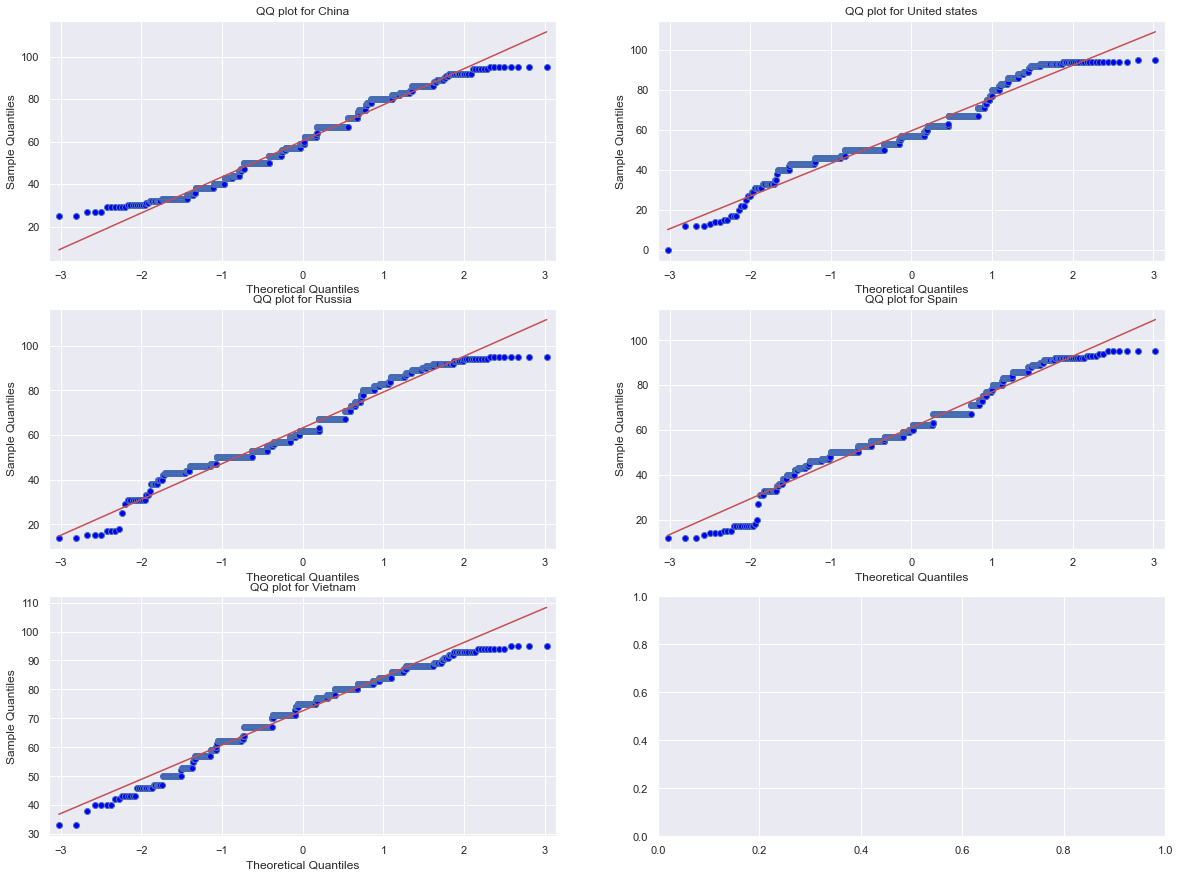

In [56]:
# plotting the histograms
fig, axes = plt.subplots(3, 2, figsize=(20,15))

sm.qqplot(fuzzy_df_cn['score'], line='s',ax=axes[0,0]);
sm.qqplot(fuzzy_df_us['score'], line='s',ax=axes[0,1]);
sm.qqplot(fuzzy_df_ru['score'], line='s',ax=axes[1,0]);
sm.qqplot(fuzzy_df_es['score'], line='s',ax=axes[1,1]);
sm.qqplot(fuzzy_df_vn['score'], line='s',ax=axes[2,0]);

axes[0,0].title.set_text('QQ plot for China')
axes[0,1].title.set_text('QQ plot for United states')
axes[1,0].title.set_text('QQ plot for Russia')
axes[1,1].title.set_text('QQ plot for Spain')
axes[2,0].title.set_text('QQ plot for Vietnam')

In [43]:
fuzzy_df_cn.head()

,password,match,score,country_code
1,123456,1234566,92,cn
2,123456,l123456,92,cn
3,123456,d123456,92,cn
4,123456,12345,91,cn
6,123456789,1234567890,95,cn


As we can see that the dataset is almost normal since the sample size is small. If we had bigger dataset it would have been a smooth curve. After plotting QQplot we can see that the dataset is normal except some outliers. 

**Checking for Homogeniety of Variance**

In [10]:
# function to get the variances and mean
def calc_mean_var(dataframe):
    """
    Calculate the count, mean and variance of the dataframe
    """
    return dataframe.mean(), dataframe.var(), dataframe.count()

In [11]:
# calculating mean and variances
mean_cn, var_cn, n_cn = calc_mean_var(fuzzy_df_cn['score'])
mean_us, var_us, n_us = calc_mean_var(fuzzy_df_us['score'])
mean_ru, var_ru, n_ru = calc_mean_var(fuzzy_df_ru['score'])
mean_es, var_es, n_es = calc_mean_var(fuzzy_df_es['score'])
mean_vn, var_vn, n_vn = calc_mean_var(fuzzy_df_vn['score'])

In [12]:
# getting variances in a single list
var = [var_cn, var_vn, var_ru, var_es, var_us]

# calculating the ratios of variances
ratios = []
for i in range(5):
    for j in range(5):
        if i!=j and i<j:
            r = var[i]/var[j]
            ratios.append(r)

ratios

[2.0569128115395454,
 1.1151021673222667,
 1.1350415543731414,
 1.0761075934600237,
 0.5421241780723034,
 0.5518180197067237,
 0.5231663624354526,
 1.0178812198874616,
 0.9650304922679129,
 0.9480777063306148]

We can see that all the ratios are less than $2.0$ or very closer to $2.0$. Hence, the variances all equal for different countries. Hence, the dataset passes the test for homogeniety of variances.

Since all the assumptions are met, we can perform ANOVA test to check for the hypothesis defined.

In [13]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

In [14]:
# calculate SSTR and update the ANOVA table
xbar = fuzzy_scores['score'].mean()
SSTR = fuzzy_scores.groupby('country_code').count() * (fuzzy_scores.groupby('country_code').mean() - xbar)**2
anova_table['SS']['Between Groups'] = SSTR['score'].sum()

In [15]:
# calculate SSE and update the ANOVA table
SSE = (fuzzy_scores.groupby('country_code').count() - 1) * fuzzy_scores.groupby('country_code').std() ** 2
anova_table['SS']['Within Groups'] = SSE['score'].sum()

In [16]:
# calculate SSTR and update the ANOVA table
fuzzy_scores['SSTR'] = fuzzy_scores.apply(lambda x: (x['score'] - xbar)**2, axis =1)
anova_table['SS']['Total'] = fuzzy_scores['SSTR'].sum()

In [17]:
# calculate degrees of freedom
anova_table['df']['Between Groups'] = fuzzy_scores['country_code'].nunique() - 1
anova_table['df']['Within Groups'] = fuzzy_scores.shape[0] - fuzzy_scores['country_code'].nunique()
anova_table['df']['Total'] = fuzzy_scores.shape[0] - 1

In [18]:
# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

In [19]:
# calculate F
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

In [20]:
# calculate p-value
anova_table['P-value']['Between Groups'] = 1 - f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

In [21]:
# calculate F critical 
alpha = 0.05

# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

In [22]:
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,91372.264109,4,22843.066027,94.611205,0.0,2.789013
Within Groups,964075.684865,3993,241.441444,,,
Total,1055447.948974,3997,264.060032,,,


We can see that the p-value is $0.0$ which is less than $\alpha = 0.05$. Hence we reject the null hypothesis. We can conlcude that the different countries does not have similar passwords. We can infer this as because of language differences.

### Hypothesis 2

Null Hypothesis: We hypothesize that the English and Spanish passwords are similar.

$$
H_0: \mu_{United States} =\mu_{Spain}
$$

Alternate Hypothesis: The passwords are not identical for English and Spanish languages.
$$
H_{\alpha}: \mu_{United States} \neq \mu_{Spain}
$$

Before performing tests for two population, we will check if the population variances are smae or not. 

In [33]:
# calculating the ratio of variances
var_us/var_es

1.054765862885166

Since the ratio of variances is less than $2$, we can assume that the two population have same variance so we will perform equal variance t-test.

In [35]:
# calculating the pooled sample variance
pooled_sample_variance = ((n_us-1) * var_us + (n_es-1) * var_es)/(n_us - 1 - n_es - 1)

In [37]:
# calculating the t-statistic
t_statistic = (mean_us - mean_es)/(pooled_sample_variance * (1/n_us + 1/n_es))
t_statistic

0.0030257041491937283

In [41]:
# calculating the p-value
p_val = 1 - t.cdf(t_statistic, df=n_us + n_es - 1)
p_val

0.49879310923918674

We  can see that $p-value = 0.498$ which is almost equal to $\alpha = 0.05$. Since we do not have any evidence to reject the null hypothesis, it might be possible that the english and spanish passwords are similar.